In [1]:
import jupyter

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.system import boot
from src.defaults import TOP2_STOCK_BY_SECTOR
from src.data.feature_pipeline import load_base_dataframe

DEVICE = boot()
OHLCV_DF = load_base_dataframe()

In [7]:
from hurst import compute_Hc
from pyts.image import RecurrencePlot
from tqdm import tqdm

In [99]:
from hurst import compute_Hc
from pyts.image import RecurrencePlot

# PROJECT SETUP ==================================
TICKERS = OHLCV_DF['symbol'].unique()#TOP2_STOCK_BY_SECTOR #["TSLA"]
CHAOS_THRESHOLD = 0.45
WINDOW_SIZE = 120
ENTROPY_BINS=10
STEP_SIZE = 20



In [100]:
def preprocess_dataframes(ohlcv_df,tickers=[]):
    dfs = {}
    for ticker in tickers:
        dfs[ticker] = ohlcv_df[ohlcv_df['symbol'] == ticker].copy()
        dfs[ticker]['return'] = dfs[ticker]['close'].pct_change()
        dfs[ticker] = dfs[ticker].dropna(subset=['return'])

    return dfs

In [101]:
from scipy.stats import entropy

def compute_entropy(series, bins=10):
    hist, _ = np.histogram(series, bins=bins, density=True)
    hist += 1e-6  # Avoid log(0)
    return entropy(hist)

In [102]:
def label_and_filter_episode_chaos_v0(results, chaos_threshold=0.45):
    walk_df = pd.DataFrame(results)
    walk_df['start_date'] = pd.to_datetime(walk_df['start_date'])

    # Label based on thresholds
    walk_df['chaotic'] = (
        (walk_df['hurst'] < chaos_threshold) &            # anti-persistent
        (walk_df['entropy'] > walk_df['entropy'].median()) &  # high randomness
        (walk_df['rec_density'] < walk_df['rec_density'].median())  # low recurrence
    )
    

    # Show summary
    print(walk_df['chaotic'].value_counts())
    chaotic_episodes = walk_df[walk_df['chaotic'] == True]
    structured_episodes = walk_df[walk_df['chaotic'] == False]
    
    return walk_df, chaotic_episodes, structured_episodes

In [103]:
def label_and_filter_episode_chaos_v1(walk_df):
    walk_df['hurst_score'] = 1 - walk_df['hurst'].rank(pct=True)
    walk_df['entropy_score'] = walk_df['entropy'].rank(pct=True)
    walk_df['rec_density_score'] = 1 - walk_df['rec_density'].rank(pct=True)
    walk_df['std_score'] = walk_df['std'].rank(pct=True)
    walk_df['kurt_score'] = walk_df['kurt'].rank(pct=True)

    # Composite chaos score (feel free to tune weights later)
    walk_df['chaos_score'] = (
        walk_df['hurst_score'] +
        walk_df['entropy_score'] +
        walk_df['rec_density_score'] +
        walk_df['std_score'] +
        walk_df['kurt_score']
    )

    threshold = walk_df['chaos_score'].median()
    walk_df['chaotic'] = walk_df['chaos_score'] > threshold

    print(walk_df['chaotic'].value_counts())

    chaotic_episodes = walk_df[walk_df['chaotic'] == True]
    structured_episodes = walk_df[walk_df['chaotic'] == False]
    
    return walk_df, chaotic_episodes, structured_episodes

In [104]:


def complexity_pipeline(datasets, window_size=120,step_size=10, chaos_threshold=0.45,entropy_bins=10):
    results = []
    for ticker in tqdm(datasets.keys()):
        df = datasets[ticker].copy()
        ticker = df.iloc[0]["symbol"]
        for start in range(0, len(df) - window_size, step_size):
            end = start + window_size
            window_returns = df['return'].iloc[start:end].dropna()

            # If all values are zero, all nan, or window too short, skip
            if len(window_returns) < 16 or np.allclose(window_returns.values, 0) or np.isnan(window_returns.values).all():
                H = np.nan
                recurrence_density = np.nan
            else:
                try:
                    # Hurst exponent for returns: use kind='change'
                    H, _, _ = compute_Hc(window_returns.values, kind='change', simplified=True)

                    # Recurrence plot
                    rp = RecurrencePlot()
                    X_rp = rp.fit_transform(window_returns.values.reshape(1, -1))[0]
                    recurrence_density = X_rp.mean()
                    ent = compute_entropy(window_returns.values,bins=entropy_bins)
                    std = window_returns.std()
                    skew = window_returns.skew()
                    kurt = window_returns.kurtosis()
                    results.append({
                        "ticker": ticker,
                        "start_date": df['date'].iloc[start],
                        "end_date": df['date'].iloc[end],
                        "hurst": H,
                        "entropy":ent,
                        "rec_density": recurrence_density,
                        "std":std,
                        "skew":skew,
                        "kurt":kurt,
                        
                    })
                except Exception as e:
                    H = np.nan
                    recurrence_density = np.nan
                    print('Error:', e)


    walk_df = pd.DataFrame(results)
    if not walk_df.empty:
        walk_df['start_date'] = pd.to_datetime(walk_df['start_date'])

        # Plot
        fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
        ax[0].plot(walk_df['start_date'], walk_df['hurst'], label='Hurst Exponent')
        ax[0].axhline(0.5, color='gray', linestyle='--')
        ax[0].set_title("Walkforward Hurst Exponent")
        ax[0].legend()
        ax[1].plot(walk_df['start_date'], walk_df['rec_density'], label='Recurrence Density', color='orange')
        ax[1].set_title("Walkforward Recurrence Plot Density")
        ax[1].legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No valid windows, walk_df is empty.")
    return walk_df 

100%|██████████| 37/37 [00:00<00:00, 457.27it/s]


100%|██████████| 37/37 [00:00<00:00, 510.83it/s]


100%|██████████| 37/37 [00:00<00:00, 504.92it/s]


100%|██████████| 37/37 [00:00<00:00, 484.85it/s]


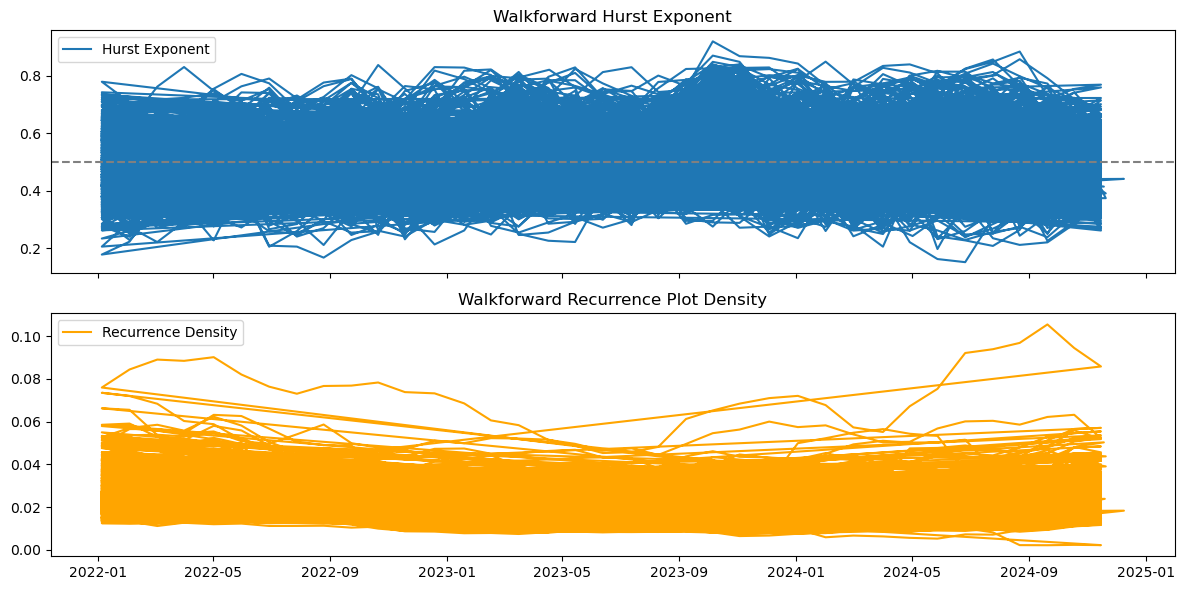

,ticker,start_date,end_date,hurst,entropy,rec_density,std,skew,kurt
0,MMM,2022-01-05,2022-06-29,0.655646,1.878617,0.017350,0.015760,0.005918,0.863584
1,MMM,2022-02-03,2022-07-28,0.583756,1.863434,0.017271,0.015854,0.293229,1.316599
2,MMM,2022-03-04,2022-08-25,0.456443,1.841125,0.016338,0.014863,0.244617,1.021262
3,MMM,2022-04-01,2022-09-23,0.493074,1.540771,0.018826,0.018154,-0.896693,5.554201
4,MMM,2022-05-02,2022-10-21,0.559217,1.599317,0.020090,0.019146,-0.678559,4.471145
...,...,...,...,...,...,...,...,...,...
18533,SPY,2024-07-25,2025-01-16,0.619972,1.842391,0.009621,0.009017,-0.547909,1.784653
18534,SPY,2024-08-22,2025-02-14,0.616225,1.749293,0.008502,0.007918,-0.591469,2.010057
18535,SPY,2024-09-20,2025-03-17,0.425517,1.834098,0.009400,0.008715,-0.535122,1.411265
18536,SPY,2024-10-18,2025-04-14,0.491372,1.081687,0.013820,0.015613,1.707847,18.957318


In [105]:
# MAIN LOOP ===============================
datasets = preprocess_dataframes(OHLCV_DF,TICKERS)
walk_df = complexity_pipeline(
    datasets,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE,
    entropy_bins=ENTROPY_BINS
)
walk_df

In [106]:
walk_df, chaotic_episodes, structured_episodes = label_and_filter_episode_chaos_v1(walk_df)

chaotic
False    9269
True     9269
Name: count, dtype: int64


In [107]:
def extract_episode(ohlcv_df, ticker, start_date,end_date):
    df = ohlcv_df[(ohlcv_df['symbol']==ticker) & (ohlcv_df['date']>=start_date) & (ohlcv_df['date']<end_date)]
    return df.set_index('date')

<Axes: title={'center': 'Chaotic episode'}, xlabel='date'>

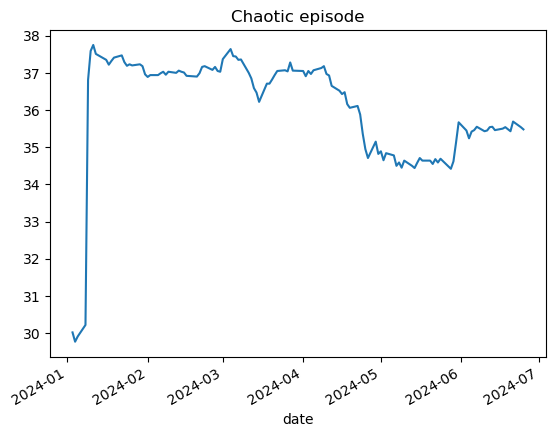

In [108]:
#chaotic_sample = chaotic_episodes.iloc[0]
chaotic_sample= walk_df.sort_values(by="chaos_score").iloc[-1]
chaotic_episode = extract_episode(OHLCV_DF,chaotic_sample['ticker'],chaotic_sample['start_date'],chaotic_sample['end_date'])
chaotic_episode['close'].plot(title="Chaotic episode")


<Axes: xlabel='date'>

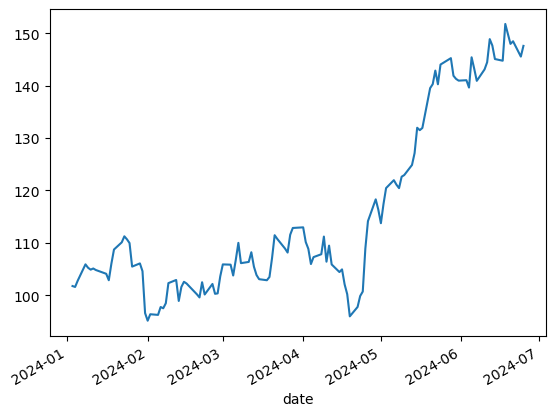

In [109]:
#sample= structured_episodes.iloc[0]
sample= walk_df.sort_values(by="chaos_score").iloc[0]
structured_episode = extract_episode(OHLCV_DF,sample['ticker'],sample['start_date'],sample['end_date'])
structured_episode['close'].plot()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


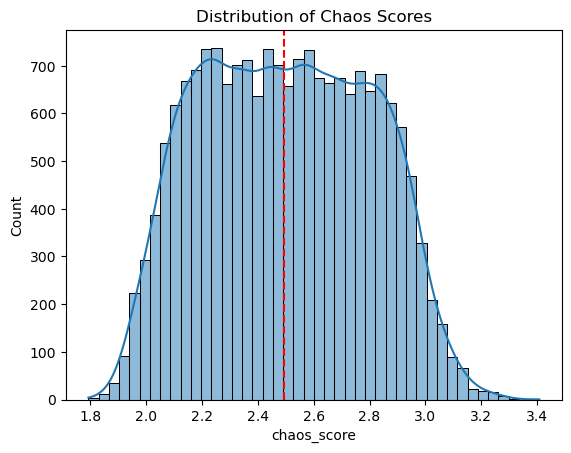

In [110]:
sns.histplot(walk_df['chaos_score'], kde=True)
plt.axvline(walk_df['chaos_score'].median(), color='red', linestyle='--')
plt.title("Distribution of Chaos Scores")
plt.show()

# Predict the future chaos

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import ace_tools_open as tools

def build_random_forest_chaos_predictor(walk_df, feature_lag_days=30):
    features = []
    labels = []
    dates = []

    for i, row in walk_df.iterrows():
        prior = walk_df[
            (walk_df['start_date'] < row['start_date']) &
            (walk_df['start_date'] >= row['start_date'] - pd.Timedelta(days=feature_lag_days))
        ]

        if len(prior) < 1:
            continue

        prior_window = prior.iloc[-1]
        features.append([
            prior_window['std'],
            prior_window['kurt'],
            prior_window['rec_density'],
            prior_window['hurst'],
            prior_window['entropy']
        ])
        labels.append(row['chaotic'])
        dates.append(row['start_date'])

    X = np.array(features)
    y = np.array(labels).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T

    # Feature importance
    feature_names = ['std', 'kurt', 'rec_density', 'hurst', 'entropy']
    importances = clf.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(8, 4))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Structured", "Chaotic"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    tools.display_dataframe_to_user(name="Chaos Meta-Model Report (Random Forest)", dataframe=report_df)

    return clf, report_df, importance_df

# Call: clf_rf, chaos_rf_report, rf_importance = build_random_forest_chaos_predictor(walk_df)



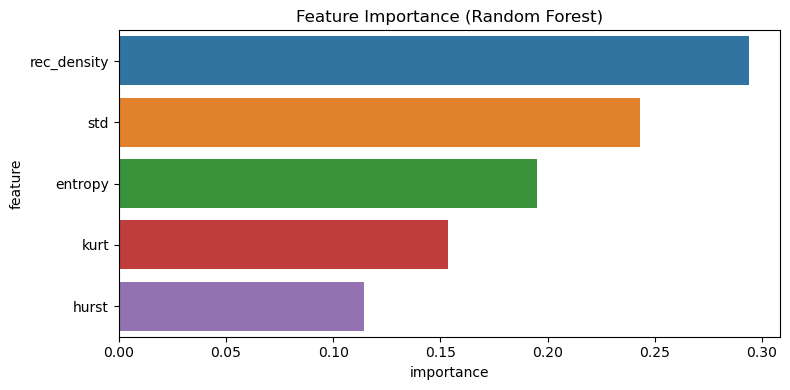

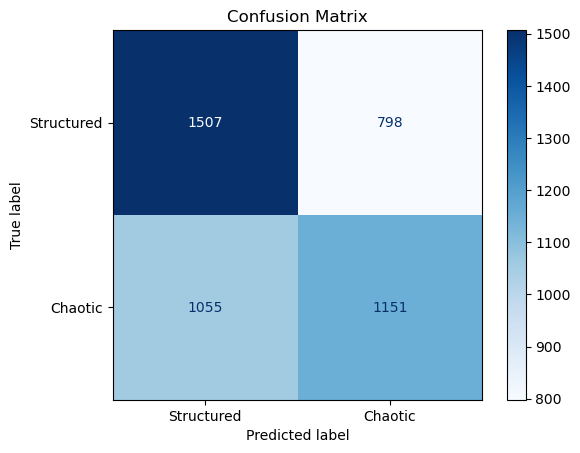

Chaos Meta-Model Report (Random Forest)


Loading ITables v2.4.0 from the internet... (need help?)


In [122]:
clf, chaos_report ,importance_df = build_random_forest_chaos_predictor(walk_df)


In [125]:

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

def build_xgboost_predictor_with_deltas(walk_df, feature_lag_days=30):
    features = []
    labels = []
    for i, row in walk_df.iterrows():
        current_start = row['start_date']
        prior = walk_df[
            (walk_df['start_date'] < current_start) &
            (walk_df['start_date'] >= current_start - pd.Timedelta(days=feature_lag_days))
        ]

        if len(prior) < 2:
            continue

        prev = prior.iloc[-1]
        prev2 = prior.iloc[-2]

        features.append([
            prev['std'],
            prev['kurt'],
            prev['rec_density'],
            prev['hurst'],
            prev['entropy'],
            prev['std'] - prev2['std'],             # Δvolatility
            prev['entropy'] - prev2['entropy'],     # Δentropy
            prev['hurst'] - prev2['hurst'],         # Δhurst
            prev['rec_density'] - prev2['rec_density']  # Δrecurrence
        ])
        labels.append(row['chaotic'])

    X = np.array(features)
    y = np.array(labels).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', XGBClassifier(n_estimators=100, max_depth=5, use_label_encoder=False, eval_metric='logloss'))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    report_df = pd.DataFrame(report).T
    report_df.loc['AUC'] = [auc, auc, auc, '-']
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Structured", "Chaotic"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    tools.display_dataframe_to_user(name="Chaos Meta-Model Report (XGBoost + Deltas)", dataframe=report_df)

    return pipe, report_df



C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:41:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


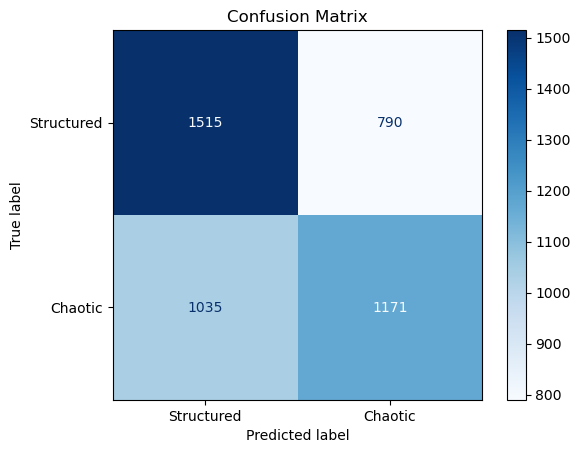

Chaos Meta-Model Report (XGBoost + Deltas)


Loading ITables v2.4.0 from the internet... (need help?)


In [126]:
clf_xgb, report_xgb = build_xgboost_predictor_with_deltas(walk_df)

# So far not satisfatory, lets go for a transformer 


In [139]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

class ChaosSequenceDataset(Dataset):
    def __init__(self, walk_df, sequence_length=5, feature_cols=None):
        self.sequence_length = sequence_length
        self.samples = []

        if feature_cols is None:
            feature_cols = ['std', 'kurt', 'rec_density', 'hurst', 'entropy']

        df = walk_df.copy()
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        df = df.sort_values(by=["ticker", "start_date"]).reset_index(drop=True)

        for ticker, group in df.groupby("ticker"):
            group = group.reset_index(drop=True)
            for i in range(len(group) - sequence_length):
                past = group.iloc[i:i + sequence_length]
                target = group.iloc[i + sequence_length]

                if past[feature_cols].isnull().values.any() or pd.isna(target['chaotic']):
                    continue

                X = past[feature_cols].values.astype(np.float32)
                y = int(target['chaotic'])

                self.samples.append((X, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        return torch.tensor(X), torch.tensor(y)


In [140]:
import torch
import torch.nn as nn

class ChaosTransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)  # Mean pooling over sequence
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_dim)
        """
        x = self.input_projection(x)  # (B, T, d_model)
        x = self.transformer_encoder(x)  # (B, T, d_model)
        x = x.mean(dim=1)  # (B, d_model) - simple mean pooling
        return self.classifier(x).squeeze(-1)  # (B,)


In [141]:
model = ChaosTransformerClassifier(input_dim=5)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} - Loss: {total_loss:.4f}")

Epoch 0 - Loss: 399.7004
Epoch 1 - Loss: 398.3314
Epoch 2 - Loss: 397.7178
Epoch 3 - Loss: 397.7998
Epoch 4 - Loss: 397.9735
Epoch 5 - Loss: 400.0160
Epoch 6 - Loss: 398.8071
Epoch 7 - Loss: 398.0138
Epoch 8 - Loss: 397.9499
Epoch 9 - Loss: 397.7560
Epoch 10 - Loss: 397.9007
Epoch 11 - Loss: 397.4287
Epoch 12 - Loss: 397.2497
Epoch 13 - Loss: 397.4571
Epoch 14 - Loss: 397.4381
Epoch 15 - Loss: 397.0818
Epoch 16 - Loss: 397.1533
Epoch 17 - Loss: 397.1871
Epoch 18 - Loss: 397.5930
Epoch 19 - Loss: 397.3241


              precision    recall  f1-score   support

           0       0.55      0.58      0.56      9266
           1       0.55      0.52      0.54      9267

    accuracy                           0.55     18533
   macro avg       0.55      0.55      0.55     18533
weighted avg       0.55      0.55      0.55     18533

AUC: 0.571


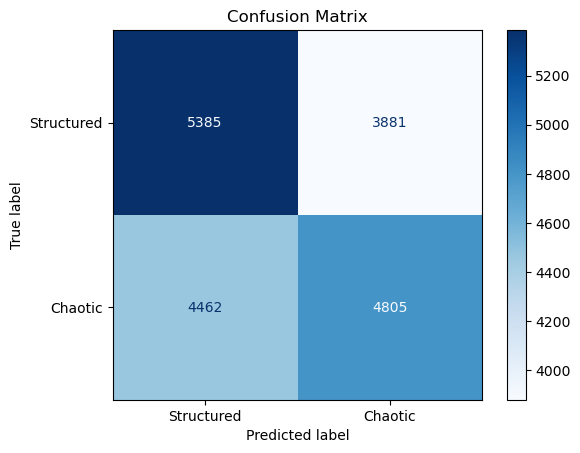

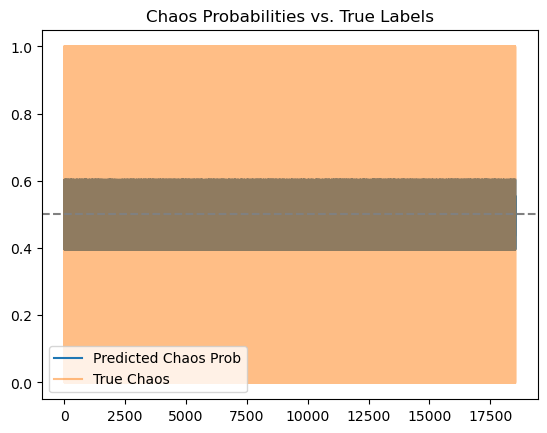

In [142]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Switch to evaluation mode
model.eval()

# Collect predictions
y_true, y_pred, y_proba = [], [], []

with torch.no_grad():
    for X, y in dataloader:
        probs = model(X).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)
        y_proba.extend(probs)

# Classification Report
print(classification_report(y_true, y_pred))

# AUC
auc_score = roc_auc_score(y_true, y_proba)
print(f"AUC: {auc_score:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Structured", "Chaotic"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Chaos Probability over Samples
plt.plot(y_proba, label="Predicted Chaos Prob")
plt.plot(y_true, label="True Chaos", alpha=0.5)
plt.axhline(0.5, linestyle='--', color='gray')
plt.title("Chaos Probabilities vs. True Labels")
plt.legend()
plt.show()


chaotic
False    9269
True     9269
Name: count, dtype: int64

In [157]:
from stable_baselines3 import PPO
from joblib import Parallel, delayed
import numpy as np
from scipy.stats import ttest_ind

def single_run(env_fn, seed, train_steps=5000, eval_episodes=3):
    # Train PPO agent
    env_train = env_fn()
    model = PPO("MlpPolicy", env_train, verbose=0, seed=seed, n_steps=128, batch_size=64)
    model.learn(total_timesteps=train_steps)

    # Evaluate PPO
    agent_rewards = []
    env_eval = env_fn()
    for _ in range(eval_episodes):
        obs, _ = env_eval.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env_eval.step(action)
            total += reward
        agent_rewards.append(total)

    # Evaluate Random Policy
    random_rewards = []
    env_rand = env_fn()
    for _ in range(eval_episodes):
        obs, done = env_rand.reset(), False
        total = 0
        while not done:
            action = env_rand.action_space.sample()
            obs, reward, done, _ = env_rand.step(action)
            total += reward
        random_rewards.append(total)

    return agent_rewards, random_rewards


def compute_agent_vs_random_advantage_parallel(
    env_fn,
    seeds=[0, 1, 2, 3, 4],
    train_steps=5000,
    eval_episodes=3,
    n_jobs=5,
    chaos_threshold=0.0,
    pval_threshold=0.05
):
    results = Parallel(n_jobs=n_jobs)(
        delayed(single_run)(env_fn, seed, train_steps, eval_episodes)
        for seed in seeds
    )

    # Flatten results
    agent_rewards = np.concatenate([a for a, _ in results])
    random_rewards = np.concatenate([r for _, r in results])

    agent_mean = np.mean(agent_rewards)
    random_mean = np.mean(random_rewards)
    advantage = agent_mean - random_mean

    # Welch’s t-test (unequal variance)
    t_stat, p_val = ttest_ind(agent_rewards, random_rewards, equal_var=False)

    # Chaos condition
    chaotic = (advantage <= chaos_threshold) and (p_val > pval_threshold)
    chaos_reason = []
    if advantage <= chaos_threshold:
        chaos_reason.append("low_advantage")
    if p_val > pval_threshold:
        chaos_reason.append("not_significant")

    return {
        "agent_mean": agent_mean,
        "random_mean": random_mean,
        "advantage": advantage,
        "p_value": p_val,
        "chaotic": chaotic,
        "chaotic_reason": "+".join(chaos_reason) if chaos_reason else "structured"
    }


In [158]:
from src.env.base_timeseries_trading_env import SequenceAwareCumulativeTradingEnv
from src.defaults import FEATURE_COLS
def label_episode_chaos(ticker, start_date, end_date, env_df):
    def env_fn():
        # Replace this with your actual environment builder using env_df
        e= SequenceAwareCumulativeTradingEnv(env_df.copy(),FEATURE_COLS)
        e.set_episode_sequence([['AAPL',721]])
        return e

    try:
        result = compute_agent_vs_random_advantage_parallel(env_fn)
        return {
            "ticker": ticker,
            "start_date": start_date,
            "end_date": end_date,
            **result
        }
    except Exception as e:
        print(f"Error at {start_date} → {end_date}: {e}")
        return None

In [159]:
label_episode_chaos('AAPL','2024-11-15','2025-05-13', OHLCV_DF[OHLCV_DF['symbol']=="AAPL"])

Error at 2024-11-15 → 2025-05-13: too many values to unpack (expected 4)


In [151]:
#e =SequenceAwareCumulativeTradingEnv(OHLCV_DF[OHLCV_DF['symbol']=="AAPL"],FEATURE_COLS)
#a,b,c = e.get_episode_by_start_date('AAPL','2024-11-15')
#b

721

In [152]:
c

3201